googledriveをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


ftrainとftestにpathを設定

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 524288)       0           conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 16853028  
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         1795971   
Total params: 18,648,999
Trainable params: 18,648,999
Non-trainable params: 0
_________________________________________________________________
Train on 209 samples, validate on 20 samples
Epoch 1/100
209/209 [==============================] - 16s 78ms/step - loss: 5034.6309 - val_loss: 4492.7575
Epoch 2/100
209/209 [==============================] - 8s 40ms/step - loss: 4464.1030 - val_loss: 4462.9053
Epoch 3/100
209/209 [==============================] - 8s 40ms/step - loss: 4451.6757 - val_loss: 4459.6806
Epoch 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

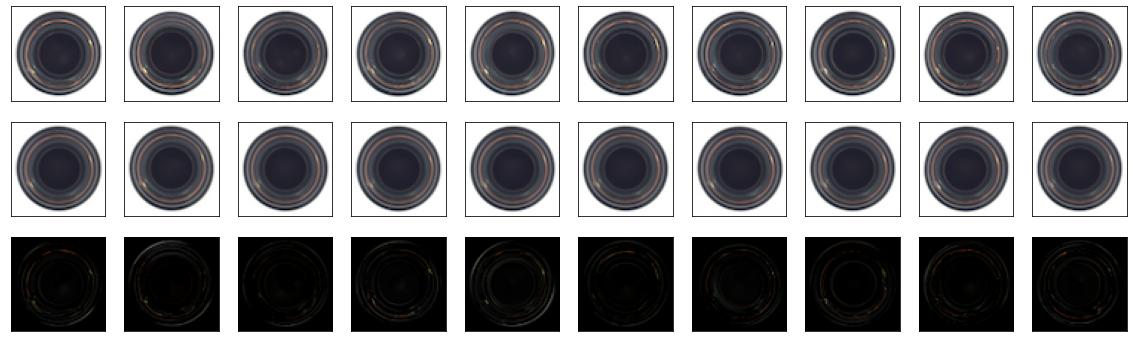

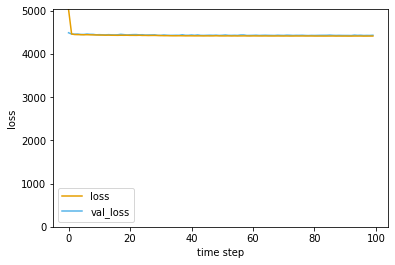

In [ ]:
  from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
import os
from PIL import Image
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers
from keras import backend as K
import cv2

ftrain = '/content/drive/My Drive//mvtec_anomaly_detection/bottle/train/good/'
ftest = '/content/drive/My Drive//mvtec_anomaly_detection/bottle/test/good/'
# MNISTデータを前処理する
train = []
test = []

files = os.listdir(ftrain)
for file in files:
    img = Image.open(ftrain + file).convert("RGB")
    img.close
    train.append(np.array(img))
train = np.array(train)
img_size = train.shape[1]
train = train.astype('float32')
train = train / 255.0
train = np.reshape(train, (len(train), img_size, img_size, 3))
files = os.listdir(ftest)
for file in files:
    img1 = Image.open(ftest + file).convert("RGB")
    img1.close
    test.append(np.array(img1))
test = np.array(test)
test = test.astype('float32')
test = test / 255.0
test = np.reshape(test, (len(test), img_size, img_size, 3))
# 入力用の変数
x = input_img = Input(shape=(img_size, img_size, 3))
batch_size = 3
latent_dim = 2
epoch = 100
x = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
# 潜在変数
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # default=random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z])
encoder.summary()
# decorder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(128, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoded)
decoder.summary()
decoded = decoder(encoder(input_img)[2])
autoencoder = Model(input_img, decoded)  # 入力と出力

# loss関数
# Compute VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img),
                                          K.flatten(decoded))
reconstruction_loss *= img_size * img_size * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# AdaDeltaで最適化, loss関数はbinary_crossentropy
autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='adam', loss='')
autoencoder.summary()
# autoencoderの実行
history = autoencoder.fit(train,  # kerasのfitメゾット
                          epochs=epoch,
                          batch_size=batch_size,
                          validation_data=(test, None))
# 画像化して確認
decoded_img = autoencoder.predict(test)

n = 10  # (表示個数)
plt.figure(figsize=(20, 6))  # 横インチ縦インチの大きさ
for i in range(n):
    # オリジナル
    origin_img = test[i].reshape(img_size, img_size, 3)
    ax = plt.subplot(3, n, i + 1)  # 何行何列何番目
    plt.imshow(origin_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)  # 軸の値非表示
    ax.get_yaxis().set_visible(False)
    # 変換された画像
    change_img = decoded_img[i].reshape(img_size, img_size, 3)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(change_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # 差分
    diff_img = origin_img - change_img
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(diff_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# 損失関数のグラフの軸ラベルを設定
plt.xlabel('time step')
plt.ylabel('loss')
# グラフ縦軸の範囲を0以上と定める
plt.ylim(0, max(np.r_[history.history['val_loss'], history.history['loss']]))
# 損失関数の時間変化を描画
val_loss, = plt.plot(history.history['val_loss'], c='#56B4E9')
loss, = plt.plot(history.history['loss'], c='#E69F00')
# グラフの凡例（はんれい）を追加
plt.legend([loss, val_loss], ['loss', 'val_loss'])
# 描画したグラフを表示
plt.show()

  